In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import natsort
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

# data 1 : URFD
- step 1 : pack each directory containing .png files as .avi file (to follow UCF format)
- step 2 : re-arange video files according to the class label
- step 3 : copy-and-paste UCF clip generation code...

In [2]:
root = '/data/FallDownData/URFD_origin/raw'
video_files = natsort.natsorted(glob.glob(root + '/*/*'))
for video in tqdm(video_files):
    prefix, ext = os.path.splitext(video)
    save_path = prefix.replace('raw', 'video') + '.avi'
    
    frame_list = natsort.natsorted(glob.glob(video+'/*'))        
    first_frame = cv2.imread(frame_list[0])
    out = cv2.VideoWriter(save_path,
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          30, (first_frame.shape[:-1][::-1]))
    for img_file in frame_list:
        img_arr = cv2.imread(img_file)
        out.write(img_arr)
        
    os.system('mkdir -p {}'.format(os.path.dirname(save_path)))
    out.release()

0it [00:00, ?it/s]


In [ ]:
# root = '/data/FallDownData/URFD/raw'
# video_files = natsort.natsorted(glob.glob(root + '/*/*'))
# for video in tqdm(video_files):
#     prefix, ext = os.path.splitext(video)
#     save_path = prefix.replace('raw', 'video') + '.avi'
    
#     frames = []
    
#     cap = cv2.VideoCapture(video)
#     frame_height, frame_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    
#     out = cv2.VideoWriter(save_path,
#                           cv2.VideoWriter_fourcc('M','J','P','G'), 
#                           30, (frame_width//2,frame_height))
    
#     while True:
#         ret, frame = cap.read()
#         if not ret:
#             break
            
#         # left : depth, right : color
#         color_frame = frame[:, frame_width//2:]
#         out.write(color_frame)

#     os.system('mkdir -p {}'.format(os.path.dirname(save_path)))
#     out.release()

# data 2 : Multicam FDD
- this dataset is bullshit!
- syncronization is not matched well

In [96]:
root = '/data/FallDownData/MulticamFD/raw'
df = pd.read_csv(os.path.join(os.path.dirname(root), 'Multicam_Annotations.csv'))

In [97]:
df.shape

(163, 5)

In [98]:
ix2label = {1: "Walking, standing up",
2 : "Falling",
3 : "Lying on the ground",
4 : "Crounching",
5 : "Moving down",
6 : "Moving up",
7 : "Sitting",
8 : "Lying on a sofa",
9 : "Moving horizontaly"}


from collections import Counter

foo = Counter(df.code.map(ix2label))
print(foo)
foo.pop("Falling")
sum(foo.values())

# df["camera_reference"].unique()

Counter({'Walking, standing up': 36, 'Moving up': 29, 'Moving down': 26, 'Falling': 25, 'Lying on the ground': 23, 'Crounching': 11, 'Sitting': 9, 'Lying on a sofa': 4})


138

In [45]:
df[df.id==1]

,id,camera_reference,start,end,code
0,1,11,874,1011,1
1,1,11,1012,1079,6
2,1,11,1080,1108,2
3,1,11,1109,1285,3


In [ ]:
# def arange_multicam_dataset(root):
videos = []

for dirpath, dirnames, filenames in os.walk(root):
    for fn in filenames:
        name, ext = os.path.splitext(fn)
        if ext == '.avi':
            videos.append(os.path.join(dirpath, fn))


videos = natsort.natsorted(videos)
scenarios = np.unique([os.path.dirname(p) for p in videos])

num_cameras = 8

import json

delays_file = "/data/FallDownData/MulticamFD/delays_multicam.json"
with open(delays_file, 'r') as json_file:
    delays = json.load(json_file)

for scenario in tqdm(scenarios):
    scenario_id = eval(os.path.basename(scenario).split('chute')[1].lstrip('0'))
    scenario_video_home = os.path.dirname(scenario).replace('raw', 'video')

    syncronized = []
    for i in range(1,num_cameras+1):
        vpath = os.path.join(scenario, f'cam{i}.avi')
        # Delay of this camara for this scenario
        delay = delays['camera{}'.format(i)][str(scenario_id)]
        
        print(scenario, f"cam:{i}, delay:{delay}")

        cap = cv2.VideoCapture(vpath)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        syncronized.append(frames[delay:])

    for seg_ix, (start, end, code) in enumerate(df[df.id==scenario_id][["start","end","code"]].values):

        label = 'fall' if code == 2 else 'adl'
        scenario_video = os.path.join(scenario_video_home, label)

        os.system('mkdir -p {}'.format(scenario_video))

        for i in range(1,num_cameras+1):
            subclip = np.array(syncronized[i-1])[start:end]
            seg_ix_str = str(seg_ix+1).zfill(2)
            vpath = os.path.join(scenario, f'cam{i}.avi')
            scenario_indicator = os.path.basename(scenario)

            seg_vpath = os.path.join(scenario_video, f'{scenario_indicator}-cam{i}-s{seg_ix_str}.avi')

            frame_height, frame_width = subclip[0].shape[:2]

            fps = cv2.VideoCapture(vpath).get(cv2.CAP_PROP_FPS)

            out = cv2.VideoWriter(seg_vpath,
                              cv2.VideoWriter_fourcc('M','J','P','G'), 
                              fps, (frame_width,frame_height))

            for frame in subclip:
                out.write(frame)

                    
# arange_multicam_dataset(root)

  0%|          | 0/24 [00:00<?, ?it/s]

/data/FallDownData/MulticamFD/raw/chute01 cam:1, delay:3
/data/FallDownData/MulticamFD/raw/chute01 cam:2, delay:3
/data/FallDownData/MulticamFD/raw/chute01 cam:3, delay:8
/data/FallDownData/MulticamFD/raw/chute01 cam:4, delay:4
/data/FallDownData/MulticamFD/raw/chute01 cam:5, delay:23
/data/FallDownData/MulticamFD/raw/chute01 cam:6, delay:6
/data/FallDownData/MulticamFD/raw/chute01 cam:7, delay:6
/data/FallDownData/MulticamFD/raw/chute01 cam:8, delay:0


  4%|▍         | 1/24 [01:28<33:59, 88.69s/it]

/data/FallDownData/MulticamFD/raw/chute02 cam:1, delay:25
/data/FallDownData/MulticamFD/raw/chute02 cam:2, delay:40
/data/FallDownData/MulticamFD/raw/chute02 cam:3, delay:0
/data/FallDownData/MulticamFD/raw/chute02 cam:4, delay:16
/data/FallDownData/MulticamFD/raw/chute02 cam:5, delay:18
/data/FallDownData/MulticamFD/raw/chute02 cam:6, delay:33
/data/FallDownData/MulticamFD/raw/chute02 cam:7, delay:33
/data/FallDownData/MulticamFD/raw/chute02 cam:8, delay:6


  8%|▊         | 2/24 [02:04<26:44, 72.93s/it]

/data/FallDownData/MulticamFD/raw/chute03 cam:1, delay:12
/data/FallDownData/MulticamFD/raw/chute03 cam:2, delay:16
/data/FallDownData/MulticamFD/raw/chute03 cam:3, delay:8
/data/FallDownData/MulticamFD/raw/chute03 cam:4, delay:16
/data/FallDownData/MulticamFD/raw/chute03 cam:5, delay:35
/data/FallDownData/MulticamFD/raw/chute03 cam:6, delay:20
/data/FallDownData/MulticamFD/raw/chute03 cam:7, delay:20
/data/FallDownData/MulticamFD/raw/chute03 cam:8, delay:0


 12%|█▎        | 3/24 [02:51<22:46, 65.08s/it]

/data/FallDownData/MulticamFD/raw/chute04 cam:1, delay:72
/data/FallDownData/MulticamFD/raw/chute04 cam:2, delay:79
/data/FallDownData/MulticamFD/raw/chute04 cam:3, delay:78
/data/FallDownData/MulticamFD/raw/chute04 cam:4, delay:0
/data/FallDownData/MulticamFD/raw/chute04 cam:5, delay:68
/data/FallDownData/MulticamFD/raw/chute04 cam:6, delay:82
/data/FallDownData/MulticamFD/raw/chute04 cam:7, delay:83
/data/FallDownData/MulticamFD/raw/chute04 cam:8, delay:56


 17%|█▋        | 4/24 [04:07<22:43, 68.19s/it]

/data/FallDownData/MulticamFD/raw/chute05 cam:1, delay:17
/data/FallDownData/MulticamFD/raw/chute05 cam:2, delay:24
/data/FallDownData/MulticamFD/raw/chute05 cam:3, delay:5
/data/FallDownData/MulticamFD/raw/chute05 cam:4, delay:11
/data/FallDownData/MulticamFD/raw/chute05 cam:5, delay:187
/data/FallDownData/MulticamFD/raw/chute05 cam:6, delay:26
/data/FallDownData/MulticamFD/raw/chute05 cam:7, delay:28
/data/FallDownData/MulticamFD/raw/chute05 cam:8, delay:0


 21%|██        | 5/24 [04:38<18:03, 57.05s/it]

/data/FallDownData/MulticamFD/raw/chute06 cam:1, delay:0
/data/FallDownData/MulticamFD/raw/chute06 cam:2, delay:100
/data/FallDownData/MulticamFD/raw/chute06 cam:3, delay:106
/data/FallDownData/MulticamFD/raw/chute06 cam:4, delay:90
/data/FallDownData/MulticamFD/raw/chute06 cam:5, delay:89
/data/FallDownData/MulticamFD/raw/chute06 cam:6, delay:103
/data/FallDownData/MulticamFD/raw/chute06 cam:7, delay:104
/data/FallDownData/MulticamFD/raw/chute06 cam:8, delay:89


 25%|██▌       | 6/24 [05:46<18:08, 60.46s/it]

/data/FallDownData/MulticamFD/raw/chute07 cam:1, delay:28
/data/FallDownData/MulticamFD/raw/chute07 cam:2, delay:14
/data/FallDownData/MulticamFD/raw/chute07 cam:3, delay:16
/data/FallDownData/MulticamFD/raw/chute07 cam:4, delay:0
/data/FallDownData/MulticamFD/raw/chute07 cam:5, delay:1
/data/FallDownData/MulticamFD/raw/chute07 cam:6, delay:17
/data/FallDownData/MulticamFD/raw/chute07 cam:7, delay:18
/data/FallDownData/MulticamFD/raw/chute07 cam:8, delay:20


 29%|██▉       | 7/24 [06:30<15:44, 55.56s/it]

/data/FallDownData/MulticamFD/raw/chute08 cam:1, delay:92
/data/FallDownData/MulticamFD/raw/chute08 cam:2, delay:79
/data/FallDownData/MulticamFD/raw/chute08 cam:3, delay:0
/data/FallDownData/MulticamFD/raw/chute08 cam:4, delay:81
/data/FallDownData/MulticamFD/raw/chute08 cam:5, delay:64
/data/FallDownData/MulticamFD/raw/chute08 cam:6, delay:81
/data/FallDownData/MulticamFD/raw/chute08 cam:7, delay:82
/data/FallDownData/MulticamFD/raw/chute08 cam:8, delay:56


 33%|███▎      | 8/24 [07:01<12:50, 48.17s/it]

/data/FallDownData/MulticamFD/raw/chute09 cam:1, delay:18
/data/FallDownData/MulticamFD/raw/chute09 cam:2, delay:9
/data/FallDownData/MulticamFD/raw/chute09 cam:3, delay:1
/data/FallDownData/MulticamFD/raw/chute09 cam:4, delay:19
/data/FallDownData/MulticamFD/raw/chute09 cam:5, delay:13
/data/FallDownData/MulticamFD/raw/chute09 cam:6, delay:11
/data/FallDownData/MulticamFD/raw/chute09 cam:7, delay:12
/data/FallDownData/MulticamFD/raw/chute09 cam:8, delay:0


 38%|███▊      | 9/24 [08:08<13:27, 53.86s/it]

/data/FallDownData/MulticamFD/raw/chute10 cam:1, delay:14
/data/FallDownData/MulticamFD/raw/chute10 cam:2, delay:15
/data/FallDownData/MulticamFD/raw/chute10 cam:3, delay:19
/data/FallDownData/MulticamFD/raw/chute10 cam:4, delay:33
/data/FallDownData/MulticamFD/raw/chute10 cam:5, delay:12
/data/FallDownData/MulticamFD/raw/chute10 cam:6, delay:17
/data/FallDownData/MulticamFD/raw/chute10 cam:7, delay:19
/data/FallDownData/MulticamFD/raw/chute10 cam:8, delay:0


 42%|████▏     | 10/24 [09:00<12:25, 53.25s/it]

/data/FallDownData/MulticamFD/raw/chute11 cam:1, delay:23
/data/FallDownData/MulticamFD/raw/chute11 cam:2, delay:4
/data/FallDownData/MulticamFD/raw/chute11 cam:3, delay:20
/data/FallDownData/MulticamFD/raw/chute11 cam:4, delay:14
/data/FallDownData/MulticamFD/raw/chute11 cam:5, delay:0
/data/FallDownData/MulticamFD/raw/chute11 cam:6, delay:6
/data/FallDownData/MulticamFD/raw/chute11 cam:7, delay:7
/data/FallDownData/MulticamFD/raw/chute11 cam:8, delay:12


 46%|████▌     | 11/24 [09:38<10:31, 48.60s/it]

/data/FallDownData/MulticamFD/raw/chute12 cam:1, delay:21
/data/FallDownData/MulticamFD/raw/chute12 cam:2, delay:16
/data/FallDownData/MulticamFD/raw/chute12 cam:3, delay:13
/data/FallDownData/MulticamFD/raw/chute12 cam:4, delay:8
/data/FallDownData/MulticamFD/raw/chute12 cam:5, delay:0
/data/FallDownData/MulticamFD/raw/chute12 cam:6, delay:3
/data/FallDownData/MulticamFD/raw/chute12 cam:7, delay:7
/data/FallDownData/MulticamFD/raw/chute12 cam:8, delay:0


 50%|█████     | 12/24 [10:33<10:05, 50.47s/it]

/data/FallDownData/MulticamFD/raw/chute13 cam:1, delay:16
/data/FallDownData/MulticamFD/raw/chute13 cam:2, delay:33
/data/FallDownData/MulticamFD/raw/chute13 cam:3, delay:0
/data/FallDownData/MulticamFD/raw/chute13 cam:4, delay:7
/data/FallDownData/MulticamFD/raw/chute13 cam:5, delay:27
/data/FallDownData/MulticamFD/raw/chute13 cam:6, delay:27
/data/FallDownData/MulticamFD/raw/chute13 cam:7, delay:36
/data/FallDownData/MulticamFD/raw/chute13 cam:8, delay:13


In [162]:
[ len(j) for j in syncronized ]

[750, 750, 750, 750, 581, 750, 750, 750]

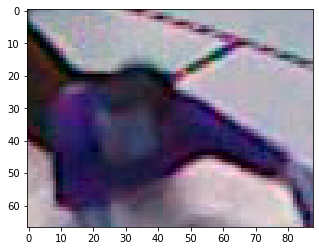

In [25]:
cap = cv2.VideoCapture('/data/FallDownData/MulticamFD/video/fall/chute09-cam6-s05.avi')

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

def check_detection_result(img, box):
    #bx,by,bw,bh = 307.466186523,196.785614014,86.6007080078,166.478393555
    bx,by,bw,bh = box
    xmin, ymin, xmax, ymax = int(bx-bw/2), int(by-bh/2), int(bx+bw/2), int(by+bh/2)
    return img[ymin:ymax, xmin:xmax]

plt.imshow(check_detection_result(frames[16], (370.211120605,174.12197876,88.2487030029,67.7461776733)))

In [ ]:
plt.imshow(frames[17])

In [123]:
fall_videos = natsort.natsorted(glob.glob('/data/FallDownData/URFD/video/fall/*.avi'))
len(fall_videos)

fall_frame_cnt = 0
L = 10
for v in fall_videos:
    if "cam1" in v:
        continue
    cap = cv2.VideoCapture(v)
    n = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(v, n)
    
    fall_frame_cnt += n
print(fall_frame_cnt, len(fall_videos))

/data/FallDownData/URFD/video/fall/fall-02-cam0-rgb.avi 110.0
/data/FallDownData/URFD/video/fall/fall-03-cam0-rgb.avi 215.0
/data/FallDownData/URFD/video/fall/fall-04-cam0-rgb.avi 96.0
/data/FallDownData/URFD/video/fall/fall-05-cam0-rgb.avi 151.0
/data/FallDownData/URFD/video/fall/fall-06-cam0-rgb.avi 100.0
/data/FallDownData/URFD/video/fall/fall-07-cam0-rgb.avi 156.0
/data/FallDownData/URFD/video/fall/fall-08-cam0-rgb.avi 91.0
/data/FallDownData/URFD/video/fall/fall-09-cam0-rgb.avi 185.0
/data/FallDownData/URFD/video/fall/fall-10-cam0-rgb.avi 130.0
/data/FallDownData/URFD/video/fall/fall-11-cam0-rgb.avi 130.0
/data/FallDownData/URFD/video/fall/fall-12-cam0-rgb.avi 110.0
/data/FallDownData/URFD/video/fall/fall-13-cam0-rgb.avi 85.0
/data/FallDownData/URFD/video/fall/fall-14-cam0-rgb.avi 61.0
/data/FallDownData/URFD/video/fall/fall-15-cam0-rgb.avi 71.0
/data/FallDownData/URFD/video/fall/fall-16-cam0-rgb.avi 55.0
/data/FallDownData/URFD/video/fall/fall-17-cam0-rgb.avi 95.0
/data/FallDownD

In [126]:
8941/2835

3.1537918871252204

In [125]:
11036/900

12.262222222222222

In [75]:
train_list = pd.read_csv("/data/FallDownData/MulticamFD/TrainTestlist/trainlist01.txt", sep=" ", names=["id", "lab"])
test_list = pd.read_csv("/data/FallDownData/MulticamFD/TrainTestlist/testlist01.txt", sep=" ", names=["id", "lab"])
# len(train_list[train_list.lab != 1]) + len(test_list[test_list.lab != 1])
len(train_list) + len(test_list)

912

In [ ]:
with open('/data/torch_data/UCF-101/ucfTrainTestlist/trainlist01.txt') as f:
    ucfList = f.readlines()
    labels = [ line.strip().split()[1] for line in ucfList ]

In [ ]:
np.unique(labels, return_counts=True)

# Create Traintests-plit for cross-validation

In [129]:
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
import itertools

In [154]:
def create_traintestList(root, annotation_path, random_state=0, n_splits=5):
    dataset_name = os.path.basename(os.path.dirname(root.rstrip('/')))
    
    os.system(f'mkdir -p {annotation_path}')

    video_dirs = natsort.natsorted(glob.glob(root + '/*/*'))

    np.random.seed(random_state)
    np.random.shuffle(video_dirs)

    class2idx = {'adl':0, 'fall':1}

    formated_video_dirs = np.array([ x[len(root.rstrip('/'))+1:] for x in video_dirs ])
    
    # split based on scenario
#     scenarios = np.array(
#         list(set([ os.path.basename(x).split('-')[0] for x in formated_video_dirs ]))
#     )

    # split based on camera
    scenarios = np.array(
        natsort.natsorted(list(set([ os.path.basename(x).split('-')[1] for x in formated_video_dirs ]))
    ))

    loo = LeaveOneOut()
    kf = StratifiedKFold(n_splits=n_splits)
    
    data_to_split = None
    if dataset_name == 'URFD':
        data_to_split = formated_video_dirs
        formated_video_dirs = [ j for j in formated_video_dirs if "cam0" in j]
    elif dataset_name == 'MulticamFD':
        data_to_split = scenarios    
        
    def get_train_test_split(train_ix, test_ix):
        if dataset_name == 'URFD':
            _train, _test = np.array(formated_video_dirs)[train_ix], np.array(formated_video_dirs)[test_ix]
        elif dataset_name == 'MulticamFD':
            train_scenario_str, test_scenario_str = scenarios[train_ix], scenarios[test_ix]
            print(f'[splist-{k}] train : {np.unique(train_scenario_str)}, test : {np.unique(test_scenario_str)}')
            
            _test = []
            for s in test_scenario_str:
                _test.append(formated_video_dirs[np.char.find(formated_video_dirs, s) != -1])

                
            _test = list(itertools.chain(*_test))
            _train = list(set(formated_video_dirs)-set(_test))

        return _train, _test


    for k, (train_ix, test_ix) in enumerate(kf.split(formated_video_dirs, [os.path.dirname(x) for x in formated_video_dirs])):
#     for k, (train_ix, test_ix) in enumerate(loo.split(scenarios)):
        print()

#         _train, _test = get_train_test_split(train_ix, test_ix)
        _train, _test = np.array(formated_video_dirs)[train_ix], np.array(formated_video_dirs)[test_ix]
    
        _train_lab = [ os.path.dirname(x) for x in _train ]
        _test_lab = [ os.path.dirname(x) for x in _test ]
        print()
        print(f'[splist-{k}] train : {np.unique(_train_lab, return_counts=True)}, test : {np.unique(_test_lab, return_counts=True)}')
        for _split, _data in zip(['train', 'test'], [_train, _test]):
            lines = []
            for i in range(len(_data)):
                line = os.path.splitext(_data[i])[0] + " "
                line += str(class2idx[os.path.dirname(_data[i])])

                lines.append(line + '\n')

            with open(os.path.join(annotation_path, f"{_split}list{k+1:02d}.txt"), 'w') as fp:
                fp.writelines(lines)

In [155]:
# URFD
create_traintestList(root = '/data/FallDownData/URFD/video',
                     annotation_path = '/data/FallDownData/URFD/TrainTestlist',
                     n_splits=5)



[splist-0] train : (array(['adl', 'fall'], dtype='<U4'), array([32, 23])), test : (array(['adl', 'fall'], dtype='<U4'), array([8, 6]))


[splist-1] train : (array(['adl', 'fall'], dtype='<U4'), array([32, 23])), test : (array(['adl', 'fall'], dtype='<U4'), array([8, 6]))


[splist-2] train : (array(['adl', 'fall'], dtype='<U4'), array([32, 23])), test : (array(['adl', 'fall'], dtype='<U4'), array([8, 6]))


[splist-3] train : (array(['adl', 'fall'], dtype='<U4'), array([32, 23])), test : (array(['adl', 'fall'], dtype='<U4'), array([8, 6]))


[splist-4] train : (array(['adl', 'fall'], dtype='<U4'), array([32, 24])), test : (array(['adl', 'fall'], dtype='<U4'), array([8, 5]))


In [137]:
# MulticamFD
create_traintestList(root = '/data/FallDownData/MulticamFD/video',
                     annotation_path = '/data/FallDownData/MulticamFD/TrainTestlist')

['cam1' 'cam2' 'cam3' 'cam4' 'cam5' 'cam6' 'cam7' 'cam8']

[splist-0] train : ['cam2' 'cam3' 'cam4' 'cam5' 'cam6' 'cam7' 'cam8'], test : ['cam1']

[splist-0] train : (array(['adl', 'fall'], dtype='<U4'), array([966, 175])), test : (array(['adl', 'fall'], dtype='<U4'), array([138,  25]))

[splist-1] train : ['cam1' 'cam3' 'cam4' 'cam5' 'cam6' 'cam7' 'cam8'], test : ['cam2']

[splist-1] train : (array(['adl', 'fall'], dtype='<U4'), array([966, 175])), test : (array(['adl', 'fall'], dtype='<U4'), array([138,  25]))

[splist-2] train : ['cam1' 'cam2' 'cam4' 'cam5' 'cam6' 'cam7' 'cam8'], test : ['cam3']

[splist-2] train : (array(['adl', 'fall'], dtype='<U4'), array([966, 175])), test : (array(['adl', 'fall'], dtype='<U4'), array([138,  25]))

[splist-3] train : ['cam1' 'cam2' 'cam3' 'cam5' 'cam6' 'cam7' 'cam8'], test : ['cam4']

[splist-3] train : (array(['adl', 'fall'], dtype='<U4'), array([966, 175])), test : (array(['adl', 'fall'], dtype='<U4'), array([138,  25]))

[splist-4] train : ['

In [ ]:
LeaveOneOut()